In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))

100%|██████████| 1971/1971 [00:53<00:00, 36.85it/s] 


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)


In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]



In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

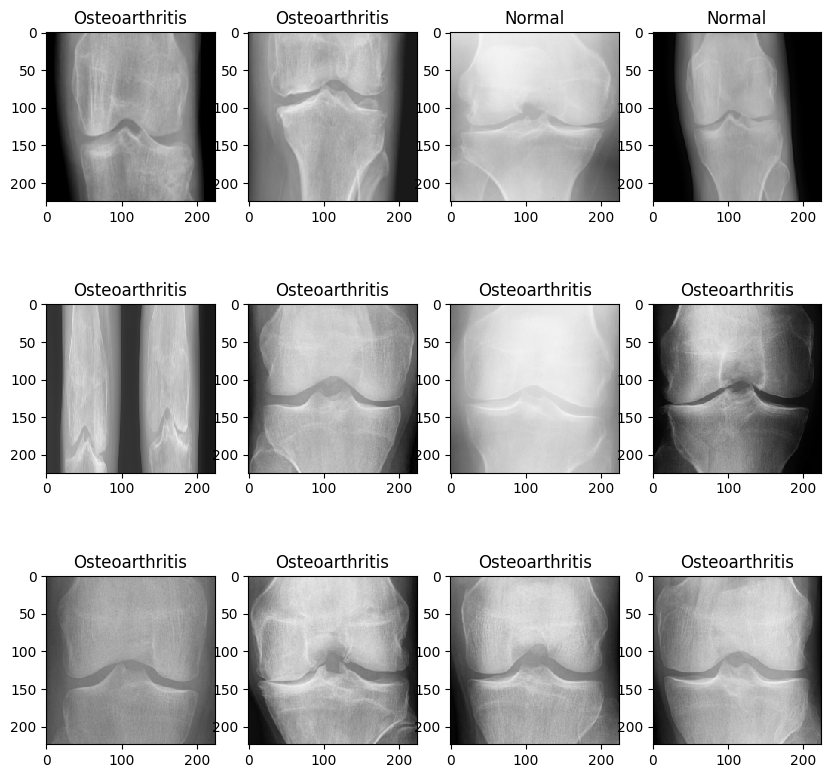

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
#nas      = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)
# vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
outputs = GlobalAveragePooling2D()(dennet)
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(64,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/best_dennet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
75/74 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.6522

74/74 [==============================] - 128s 1s/step - loss: 0.6903 - accuracy: 0.6522 - val_loss: 0.7694 - val_accuracy: 0.6010 - lr: 1.0000e-04
Epoch 2/40
75/74 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7069

74/74 [==============================] - 53s 700ms/step - loss: 0.5862 - accuracy: 0.7069 - val_loss: 0.6505 - val_accuracy: 0.7179 - lr: 1.0000e-04
Epoch 3/40
75/74 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7429

74/74 [==============================] - 57s 757ms/step - loss: 0.5385 - accuracy: 0.7429 - val_loss: 0.3727 - val_accuracy: 0.8314 - lr: 1.0000e-04
Epoch 4/40
75/74 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.7625

74/74 [==============================] - 52s 696ms/step - loss: 0.5116 - accuracy: 0.7625 - val_loss: 0.7794 - val_accuracy: 0.7379 - lr: 1.0000e-04
Epoch 5/40
75/74 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.7676

74/74 [==============================] - 53s 709ms/step - loss: 0.4976 - accuracy: 0.7676 - val_loss: 0.3053 - val_accuracy: 0.8865 - lr: 1.0000e-04
Epoch 6/40
75/74 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.7897

74/74 [==============================] - 52s 699ms/step - loss: 0.4593 - accuracy: 0.7897 - val_loss: 0.7810 - val_accuracy: 0.7596 - lr: 1.0000e-04
Epoch 7/40
75/74 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.7860

74/74 [==============================] - 54s 711ms/step - loss: 0.4420 - accuracy: 0.7860 - val_loss: 0.3698 - val_accuracy: 0.8815 - lr: 1.0000e-04
Epoch 8/40
75/74 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.7935

74/74 [==============================] - 55s 731ms/step - loss: 0.4376 - accuracy: 0.7935 - val_loss: 0.5344 - val_accuracy: 0.7279 - lr: 1.0000e-04
Epoch 9/40
75/74 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8006

74/74 [==============================] - 55s 736ms/step - loss: 0.4327 - accuracy: 0.8006 - val_loss: 0.3257 - val_accuracy: 0.8765 - lr: 1.0000e-04
Epoch 10/40
75/74 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8052

74/74 [==============================] - 54s 718ms/step - loss: 0.4270 - accuracy: 0.8052 - val_loss: 0.2486 - val_accuracy: 0.8965 - lr: 1.0000e-04
Epoch 11/40
75/74 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.8064

74/74 [==============================] - 55s 737ms/step - loss: 0.4225 - accuracy: 0.8064 - val_loss: 0.2926 - val_accuracy: 0.8715 - lr: 1.0000e-04
Epoch 12/40
75/74 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.8152

74/74 [==============================] - 53s 705ms/step - loss: 0.3955 - accuracy: 0.8152 - val_loss: 0.3297 - val_accuracy: 0.8564 - lr: 1.0000e-04
Epoch 13/40
75/74 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8181

74/74 [==============================] - 56s 742ms/step - loss: 0.3936 - accuracy: 0.8181 - val_loss: 0.3163 - val_accuracy: 0.8831 - lr: 1.0000e-04
Epoch 14/40
75/74 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8148

74/74 [==============================] - 53s 702ms/step - loss: 0.3926 - accuracy: 0.8148 - val_loss: 0.4286 - val_accuracy: 0.8748 - lr: 1.0000e-04
Epoch 15/40
75/74 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8240

74/74 [==============================] - 52s 693ms/step - loss: 0.3894 - accuracy: 0.8240 - val_loss: 0.3460 - val_accuracy: 0.8932 - lr: 1.0000e-04
Epoch 16/40
75/74 [==============================] - ETA: 0s - loss: 0.4056 - accuracy: 0.8152

74/74 [==============================] - 56s 745ms/step - loss: 0.4056 - accuracy: 0.8152 - val_loss: 0.3137 - val_accuracy: 0.8815 - lr: 1.0000e-04
Epoch 17/40
75/74 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8315

74/74 [==============================] - 53s 701ms/step - loss: 0.3746 - accuracy: 0.8315 - val_loss: 1.0369 - val_accuracy: 0.7830 - lr: 1.0000e-04
Epoch 18/40
75/74 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8332

74/74 [==============================] - 53s 708ms/step - loss: 0.3697 - accuracy: 0.8332 - val_loss: 0.2650 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 19/40
75/74 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8261

74/74 [==============================] - 53s 702ms/step - loss: 0.3749 - accuracy: 0.8261 - val_loss: 0.3167 - val_accuracy: 0.8481 - lr: 1.0000e-04
Epoch 20/40
75/74 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8324

74/74 [==============================] - 52s 696ms/step - loss: 0.3578 - accuracy: 0.8324 - val_loss: 0.1900 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 21/40
75/74 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8424

74/74 [==============================] - 55s 727ms/step - loss: 0.3522 - accuracy: 0.8424 - val_loss: 0.2207 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 22/40
75/74 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8457

74/74 [==============================] - 54s 725ms/step - loss: 0.3541 - accuracy: 0.8457 - val_loss: 0.5944 - val_accuracy: 0.7195 - lr: 1.0000e-04
Epoch 23/40
75/74 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8332

74/74 [==============================] - 52s 693ms/step - loss: 0.3549 - accuracy: 0.8332 - val_loss: 0.2027 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 24/40
75/74 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8303

74/74 [==============================] - 56s 750ms/step - loss: 0.3560 - accuracy: 0.8303 - val_loss: 0.3118 - val_accuracy: 0.9065 - lr: 1.0000e-04
Epoch 25/40
75/74 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8462

74/74 [==============================] - 52s 696ms/step - loss: 0.3349 - accuracy: 0.8462 - val_loss: 0.1538 - val_accuracy: 0.9516 - lr: 1.0000e-04
Epoch 26/40
75/74 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8482

74/74 [==============================] - 55s 730ms/step - loss: 0.3407 - accuracy: 0.8482 - val_loss: 0.2320 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 27/40
75/74 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8411

74/74 [==============================] - 53s 703ms/step - loss: 0.3447 - accuracy: 0.8411 - val_loss: 0.4310 - val_accuracy: 0.8815 - lr: 1.0000e-04
Epoch 28/40
75/74 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8416

74/74 [==============================] - 55s 732ms/step - loss: 0.3482 - accuracy: 0.8416 - val_loss: 0.4354 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 29/40
75/74 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8503

74/74 [==============================] - 55s 735ms/step - loss: 0.3203 - accuracy: 0.8503 - val_loss: 0.1635 - val_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 30/40
75/74 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8411

74/74 [==============================] - 53s 701ms/step - loss: 0.3348 - accuracy: 0.8411 - val_loss: 0.2083 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 31/40
75/74 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8441

74/74 [==============================] - 57s 758ms/step - loss: 0.3223 - accuracy: 0.8441 - val_loss: 0.2445 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 32/40
75/74 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8370

74/74 [==============================] - 53s 702ms/step - loss: 0.3444 - accuracy: 0.8370 - val_loss: 0.1557 - val_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 33/40
75/74 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8675

74/74 [==============================] - 55s 731ms/step - loss: 0.3007 - accuracy: 0.8675 - val_loss: 0.1598 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 34/40
75/74 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8470

74/74 [==============================] - 54s 720ms/step - loss: 0.3166 - accuracy: 0.8470 - val_loss: 0.1446 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 35/40
75/74 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8528

74/74 [==============================] - 53s 702ms/step - loss: 0.3263 - accuracy: 0.8528 - val_loss: 0.1631 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 36/40
75/74 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8457

74/74 [==============================] - 54s 724ms/step - loss: 0.3252 - accuracy: 0.8457 - val_loss: 0.2060 - val_accuracy: 0.9232 - lr: 1.0000e-04
Epoch 37/40
75/74 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8574

74/74 [==============================] - 55s 733ms/step - loss: 0.3092 - accuracy: 0.8574 - val_loss: 0.1651 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 38/40
75/74 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8424

74/74 [==============================] - 52s 691ms/step - loss: 0.3261 - accuracy: 0.8424 - val_loss: 0.2136 - val_accuracy: 0.9232 - lr: 1.0000e-04
Epoch 39/40
75/74 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8612

74/74 [==============================] - 54s 716ms/step - loss: 0.2908 - accuracy: 0.8612 - val_loss: 0.4548 - val_accuracy: 0.8614 - lr: 1.0000e-04
Epoch 40/40
75/74 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8428

74/74 [==============================] - 55s 735ms/step - loss: 0.3223 - accuracy: 0.8428 - val_loss: 0.2049 - val_accuracy: 0.9432 - lr: 1.0000e-04


19/19 [==============================] - 3s 141ms/step
Confusion matrix, without normalization
[[193   3]
 [ 31 372]]


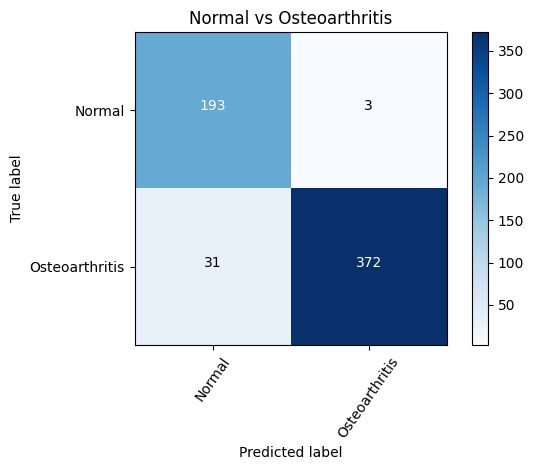

In [19]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

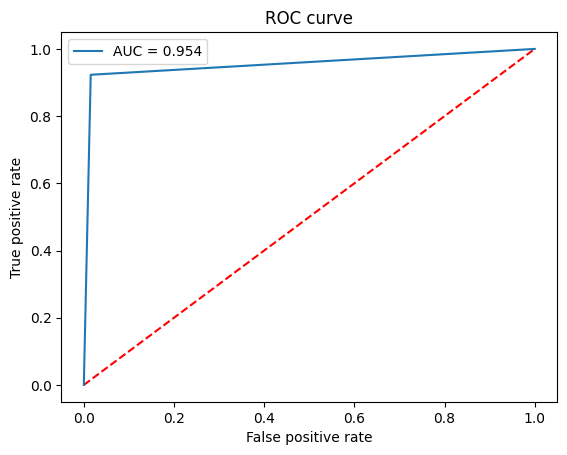

In [20]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

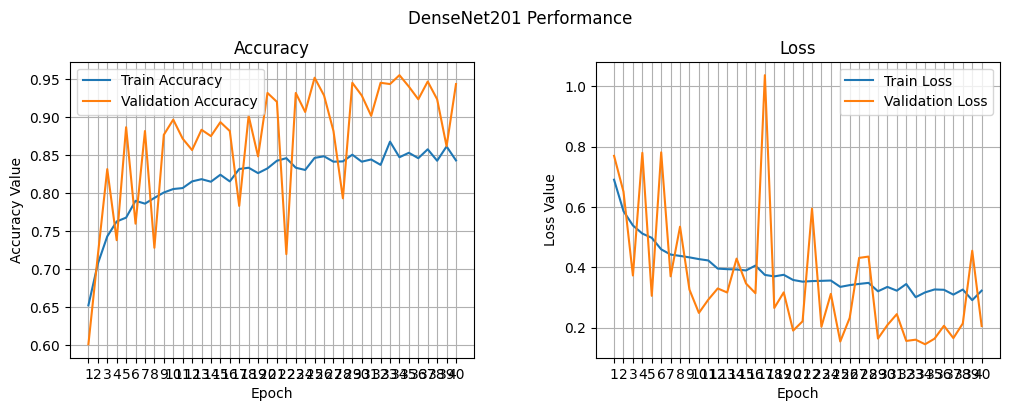

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DenseNet201 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

19/19 [==============================] - 3s 139ms/step


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Osteoarthritis']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

        Normal       0.86      0.98      0.92       196
Osteoarthritis       0.99      0.92      0.96       403

      accuracy                           0.94       599
     macro avg       0.93      0.95      0.94       599
  weighted avg       0.95      0.94      0.94       599

